In [39]:
# boas práticas: criar uma célula com todas as bibliotecas necessárias
# importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Turmas 2017.2
# http://dados.ufrn.br/dataset/turmas

# turmas
turmas_url = 'http://bit.do/turmas_ufrn_2017_2'

# matrículas em componentes em 2017.2
notas_url = 'http://bit.do/notas_ufrn_2017_2'

# componentes curriculares presenciais
disciplinas_url = 'http://bit.do/componentes_curriculares_ufrn'

# turmas 2017.2
turmas = pd.read_csv(turmas_url, sep=';')

# matriculas em componentes em 2017.2
notas = pd.read_csv(notas_url, sep=';')

# componentes curriculares presenciais
# por alguma razão ou outra, esse dataset tinha algum lixo em linhas que ocasionava 
# erros de leitura, dessa forma foi realizado um filtro apenas por colunas mais importantes
disciplinas = pd.read_csv(disciplinas_url, 
                          sep=';', 
                          usecols=["id_componente","codigo","nivel","nome","unidade_responsavel"])

In [3]:
# Adaptando o dataframe turma e disciplinas para o merge
# Esse procedimento é necessário pois o dataframe turma está codificado com ids

# A coluna id_componente precisa ser a mesma em ambos os dataframes
turmas.rename(columns={'id_componente_curricular': 'id_componente'}, inplace=True)

# id_componente em ambos os dataframes precisam ser do mesmo tipo
turmas.id_componente = turmas.id_componente.astype(str)

# Limpando o dataframe disciplinas com linhas desnecessárias
disciplinas = disciplinas[~disciplinas.id_componente.duplicated()]

# Pegando apenas as disciplinas do IMD
disciplinas = disciplinas[disciplinas.unidade_responsavel == 'INSTITUTO METROPOLE DIGITAL']

In [4]:
# Fazendo um merge entre o dataframe turmas e disciplinas utilizando como base a coluna id_componente
# https://pandas.pydata.org/pandas-docs/stable/merging.html
colunas = ["id_turma","codigo","nivel_ensino","nome","unidade_responsavel",
          "situacao_turma","capacidade_aluno","descricao_horario", "ano", "periodo"]

# merge os dois dataframes utilizando como base a coluna id_componenteb
disciplinas_turma = pd.merge(turmas, disciplinas, on='id_componente')[colunas]

In [6]:
colunas_relevantes = ["id_turma", "codigo", "nome", "descricao_horario", "ano", 
                      "periodo", "media_final", "numero_total_faltas", "descricao", "discente"]
# Merge de turma com as notas
notas_turma = pd.merge(disciplinas_turma, notas, on='id_turma')[colunas_relevantes]

In [103]:
%%javascript
// Para evitar dos graficos ficarem contidos numa caixa com scroll
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

[Text(0.5,0,'Faltas')]

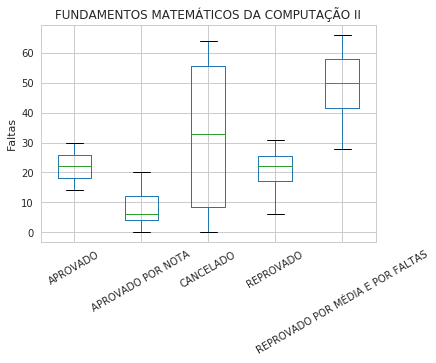

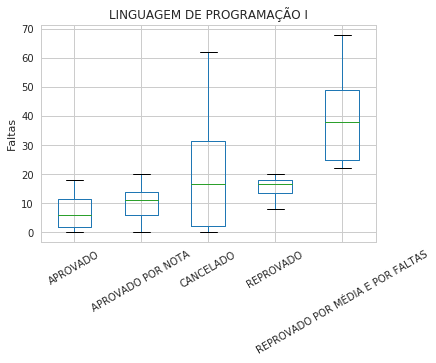

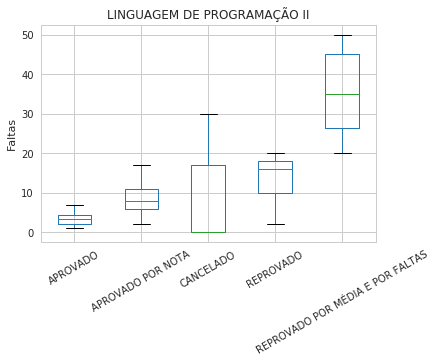

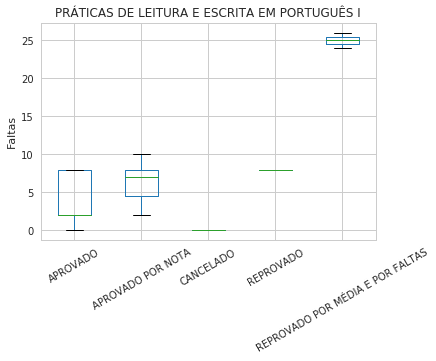

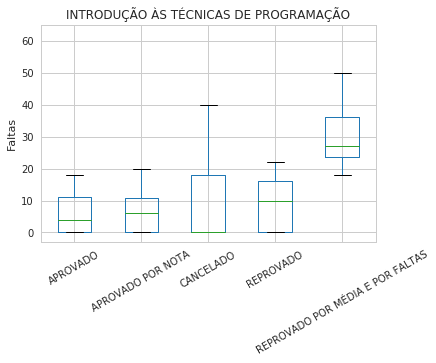

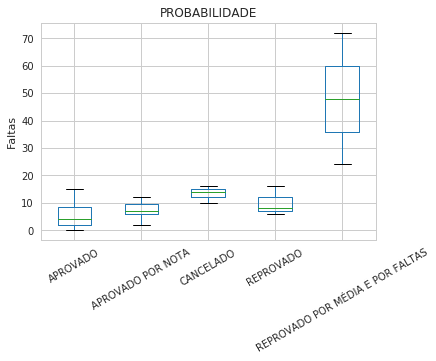

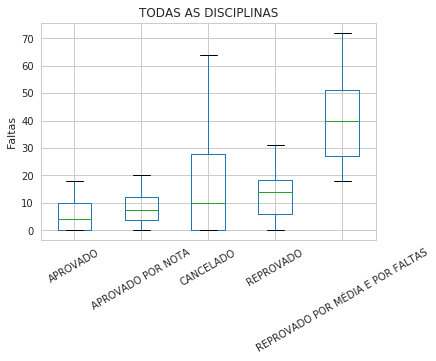

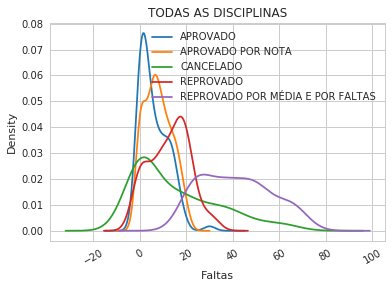

In [105]:
sns.set_style("whitegrid")

disciplinas = (
    'FUNDAMENTOS MATEMÁTICOS DA COMPUTAÇÃO II',
    'LINGUAGEM DE PROGRAMAÇÃO I',
    'LINGUAGEM DE PROGRAMAÇÃO II',
    'PRÁTICAS DE LEITURA E ESCRITA EM PORTUGUÊS I',
    'INTRODUÇÃO ÀS TÉCNICAS DE PROGRAMAÇÃO',
    'PROBABILIDADE'
)
# Aqui é gerado um dicionário em que a chave é o nome da disciplina e o valor é um dataframe contendo as
# notas para aquela disciplina. Como a disciplina tem mais de uma unidade, a quantidade de faltas aparece em um
# numero igual a quantidade de unidades. Para evitar isso e gerar incosistências na análise foi removido esses
# dados duplicados e deixado apenas um por discente.
dataframes_notas = {}
for disciplina in disciplinas:
    dataframes_notas[disciplina] = notas_turma[notas_turma.nome == disciplina].drop_duplicates('discente')
    
# Aqui percorremos o dataframes_notas, montado anteriormente, e criamos o dataframe_grupos, que também tem como 
# chave o nome das disciplinas e um dataframe contendo os grupos de aprovaçoes como colunas.
dataframes_grupos = {}
for (disciplina, dataframe) in dataframes_notas.items():
    lista_status = list(filter(lambda i : i not in ('INDEFERIDO', 'TRANCADO', 'DESISTENCIA', 'EXCLUIDA', 'REPROVADO POR NOTA'), dataframe.descricao.unique()))
    dataframe_montado = {}
    for status in lista_status:
        dataframe_montado[status] = dataframe[dataframe.descricao == status]['numero_total_faltas']
    dataframes_grupos[disciplina] = pd.DataFrame.from_dict(dataframe_montado)

# Aqui percorremos o dicionário de dataframes e criamos um gráfico para cada um.
for disciplina, dataframe in dataframes_grupos.items():
    dataframe.plot(kind='box', rot=30, title=disciplina).set(ylabel='Faltas')
   
# Graficos para um dataframe com a junção dos dataframes de todas as disciplinas
dataframe_todos = pd.concat(dataframes_grupos.values())
dataframe_todos.plot(kind='box', rot=30, title='TODAS AS DISCIPLINAS').set(ylabel='Faltas')
dataframe_todos.plot(kind='kde', rot=30, title='TODAS AS DISCIPLINAS').set(xlabel='Faltas')